# 03 — Train Models on Balanced Dataset

Uses `../data/poker_balanced_10k.csv` generated by Notebook 01_generaed_balanced_dataset.ipynb.

In [5]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import pandas as pd

# ----------------------------
# Initialize storages (once)
# ----------------------------
if 'model_results' not in globals():
    model_results = pd.DataFrame(columns=["Model", "Accuracy", "Macro F1", "Weighted F1"])
if 'model_reports' not in globals():
    model_reports = {}

stored_preds = {}

# ----------------------------
# Load BALANCED dataset
# ----------------------------
df = pd.read_csv('../data/poker_balanced_10k.csv')

# Feature/target
X = df[['S1','R1','S2','R2','S3','R3','S4','R4','S5','R5']]
y = df['ORD']

# Split (same scheme as 02)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# ----------------------------
# Define all models
# ----------------------------
models = [
    ("KNN (k=1)", KNeighborsClassifier(n_neighbors=1)),
    ("Random Forest (n=300)", RandomForestClassifier(n_estimators=300, random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("XGBoost", XGBClassifier(tree_method='hist', eval_metric='mlogloss', random_state=42)),
]

# ----------------------------
# Evaluate each model
# ----------------------------
for model_name, clf in models:
    print(f"\n=== Evaluating {model_name} ===")
    clf.fit(X_train_s, y_train)
    y_test_pred = clf.predict(X_test_s)
    stored_preds[model_name] = y_test_pred
    
    test_acc = accuracy_score(y_test, y_test_pred)
    macro_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
    weighted_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    current_report = classification_report(y_test, y_test_pred, digits=3, zero_division=0)

    if model_name in model_results["Model"].values:
        model_results.loc[model_results["Model"] == model_name, ["Accuracy", "Macro F1", "Weighted F1"]] = [
            test_acc, macro_f1, weighted_f1
        ]
    else:
        new_row = pd.DataFrame([[model_name, test_acc, macro_f1, weighted_f1]],
                               columns=["Model", "Accuracy", "Macro F1", "Weighted F1"])
        model_results = pd.concat([model_results, new_row], ignore_index=True)

    model_reports[model_name] = current_report

print("\nModel Comparison:")
display(model_results.style.format({
    "Accuracy": "{:.4f}",
    "Macro F1": "{:.4f}",
    "Weighted F1": "{:.4f}"
}))

print("\nStored Classification Reports:\n")
for name, report in model_reports.items():
    print(f"----- {name} -----")
    print(report)
    print("\n")

print("\nEvaluation complete for all models.\n")


=== Evaluating KNN (k=1) ===

=== Evaluating Random Forest (n=300) ===

=== Evaluating Gradient Boosting ===

=== Evaluating XGBoost ===

Model Comparison:


,Model,Accuracy,Macro F1,Weighted F1
0,KNN (k=1),0.6480,0.6395,0.6362
1,Random Forest (n=300),0.8420,0.8366,0.8356
2,Gradient Boosting,0.8127,0.8034,0.8021
3,XGBoost,0.9447,0.9436,0.9432



Stored Classification Reports:

----- KNN (k=1) -----
              precision    recall  f1-score   support

           0      0.553     0.263     0.356       160
           1      0.376     0.376     0.376       141
           2      0.481     0.422     0.450       154
           3      0.390     0.377     0.383       159
           4      0.700     0.732     0.716       153
           5      0.836     0.972     0.899       142
           6      0.478     0.600     0.532       145
           7      0.633     0.786     0.702       145
           8      0.971     1.000     0.985       167
           9      0.993     1.000     0.996       134

    accuracy                          0.648      1500
   macro avg      0.641     0.653     0.639      1500
weighted avg      0.640     0.648     0.636      1500



----- Random Forest (n=300) -----
              precision    recall  f1-score   support

           0      0.966     0.525     0.680       160
           1      0.656     0.610     0.6

In [6]:
import xgboost as xgb
print(xgb.__version__)

2.0.3


### Cell 2: Visualize all Stored Models(Balanced Data)


Visualizing 4 models (10 active classes)...


Showing results for: KNN (k=1)



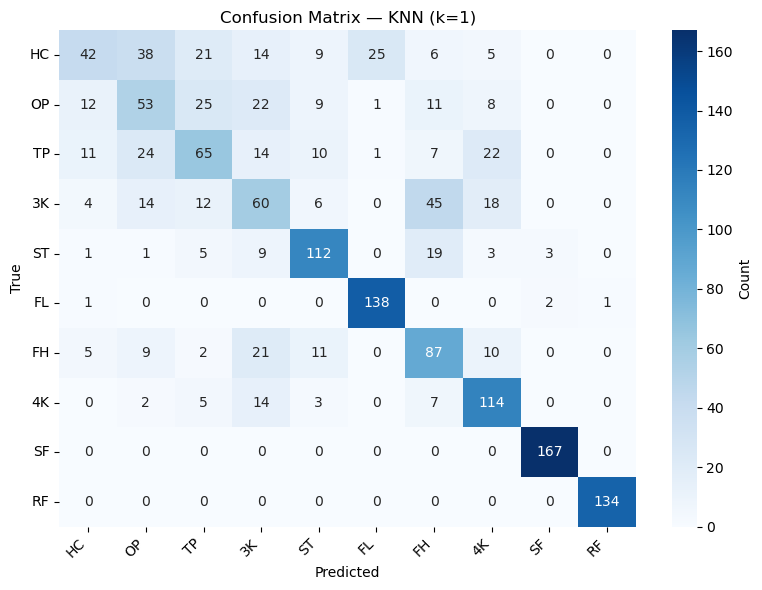

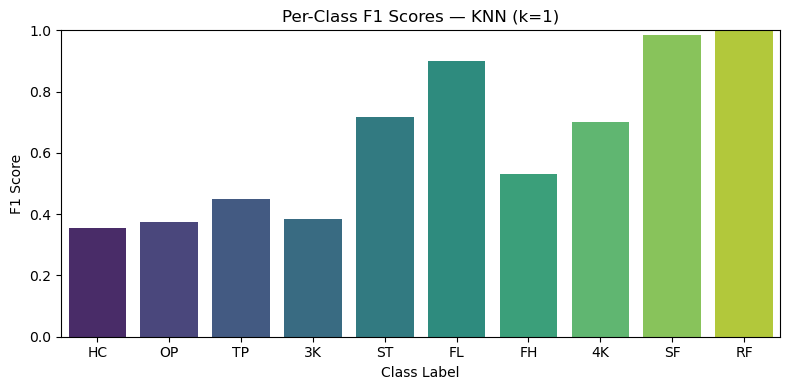

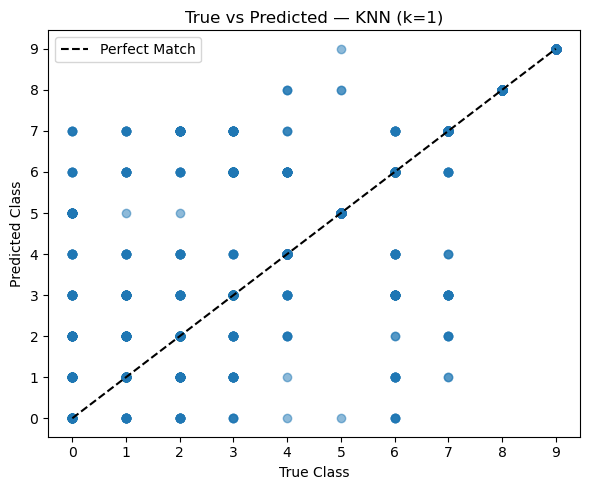

=========> MODEL SUMMARY
Model:           KNN (k=1)
Accuracy:        0.6480
Macro F1 Score:  0.6395
Weighted F1:     0.6362
-------------------------------------


Showing results for: Random Forest (n=300)



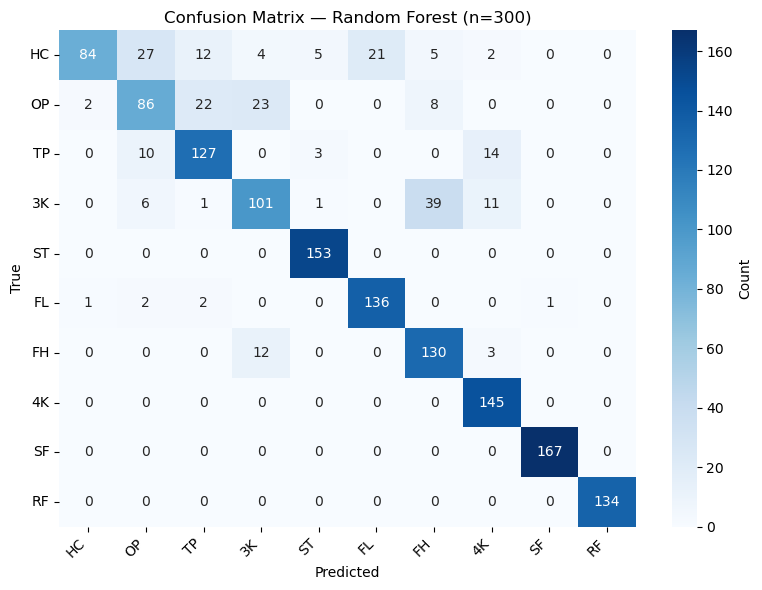

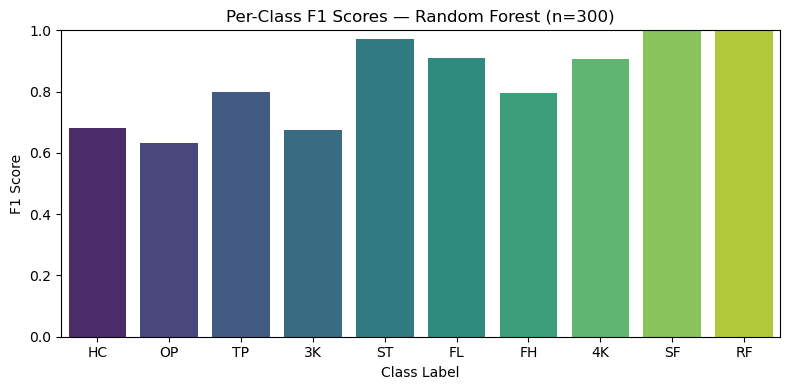

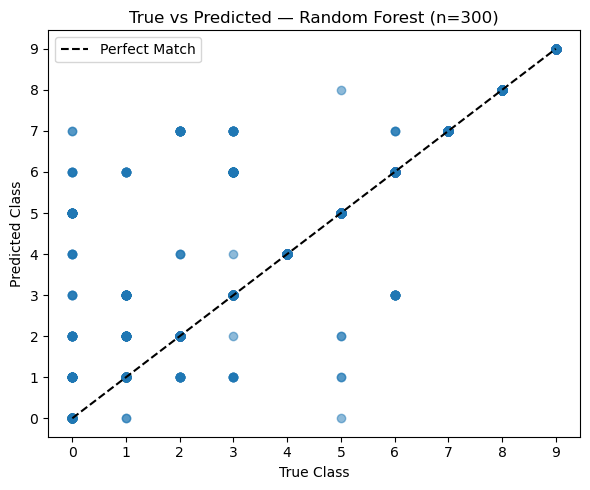

=========> MODEL SUMMARY
Model:           Random Forest (n=300)
Accuracy:        0.8420
Macro F1 Score:  0.8366
Weighted F1:     0.8356
-------------------------------------


Showing results for: Gradient Boosting



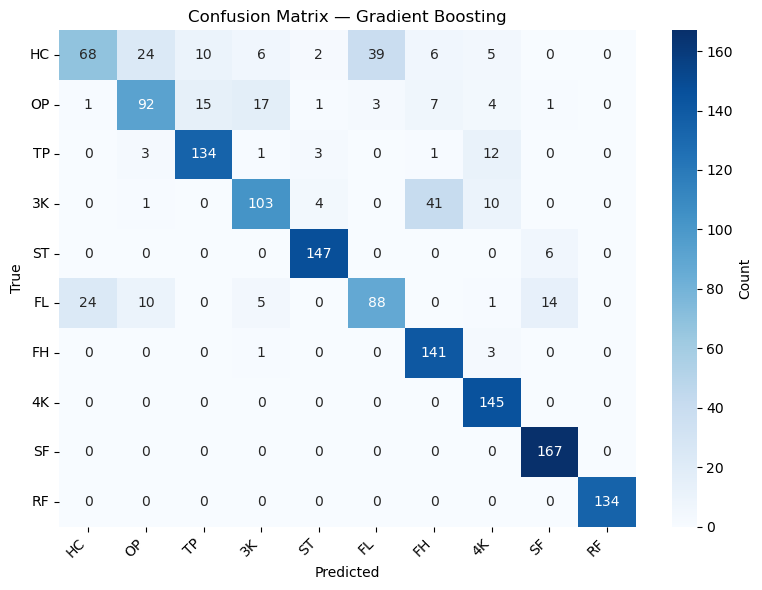

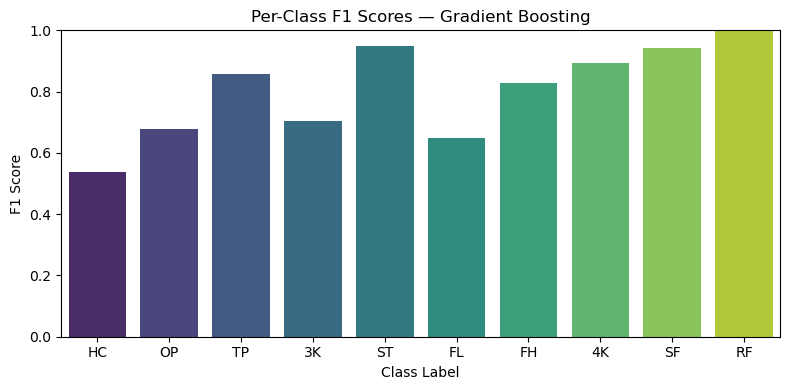

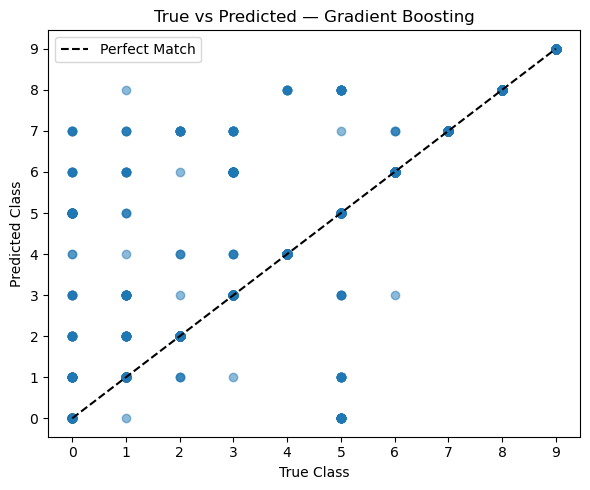

=========> MODEL SUMMARY
Model:           Gradient Boosting
Accuracy:        0.8127
Macro F1 Score:  0.8034
Weighted F1:     0.8021
-------------------------------------


Showing results for: XGBoost



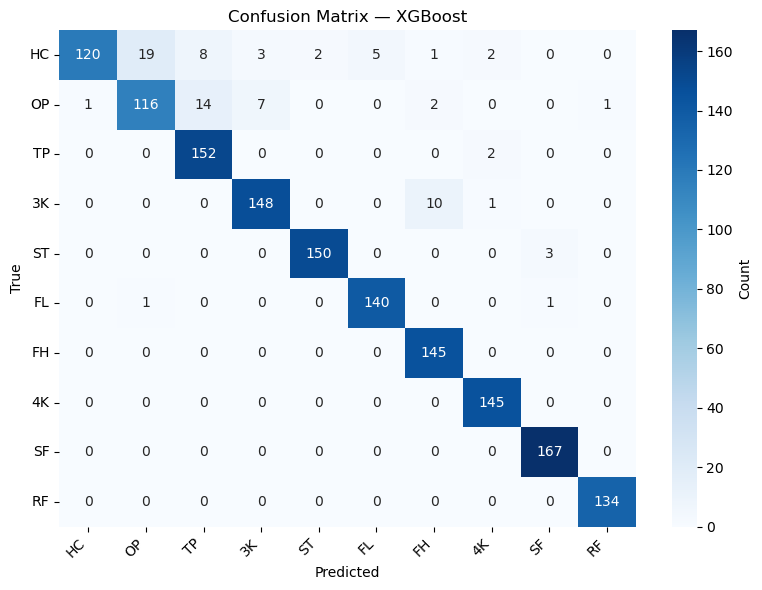

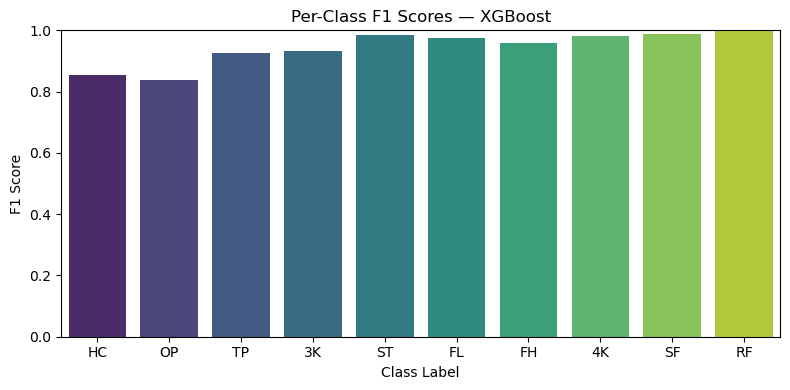

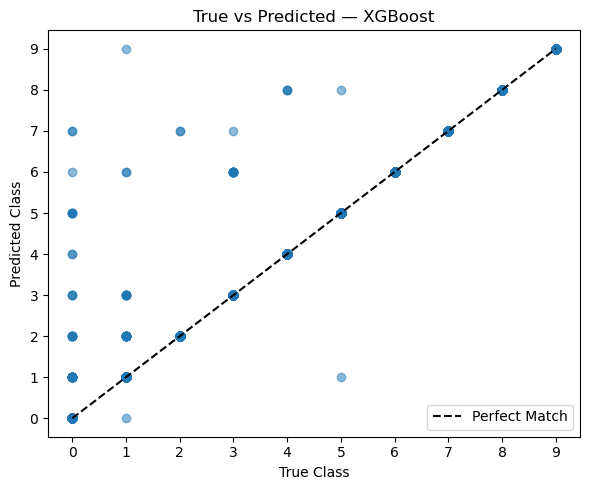

=========> MODEL SUMMARY
Model:           XGBoost
Accuracy:        0.9447
Macro F1 Score:  0.9436
Weighted F1:     0.9432
-------------------------------------


Cell 2 complete — all models visualized.



In [7]:
# ============================
# CELL 2 — Visualize ALL Stored Models (Dynamic Classes)
# ============================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import numpy as np

# Short labels
poker_labels_short = ["HC","OP","TP","3K","ST","FL","FH","4K","SF","RF"]

# Ensure predictions are stored
if 'stored_preds' not in globals() or len(stored_preds) == 0:
    raise ValueError("No stored predictions found. Run the first cell to evaluate models.")

n_classes = len(np.unique(y_test))  # dynamic class count
labels_for_plot = poker_labels_short[:n_classes]

print(f"\nVisualizing {len(stored_preds)} models ({n_classes} active classes)...\n")

for model_name, y_pred in stored_preds.items():
    print(f"\n============================")
    print(f"Showing results for: {model_name}")
    print(f"============================\n")

    # ----------------------------
    # Confusion Matrix
    # ----------------------------
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=poker_labels_short,
        yticklabels=poker_labels_short,
        cbar_kws={"label": "Count"}
    )
    plt.title(f"Confusion Matrix — {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # ----------------------------
    # Per-Class F1 Bar Chart (robust to missing classes)
    # ----------------------------
    class_f1 = f1_score(y_test, y_pred, average=None, labels=np.unique(y_test), zero_division=0)
    labels_for_plot = poker_labels_short[:len(class_f1)]

    plt.figure(figsize=(8,4))
    sns.barplot(x=labels_for_plot, y=class_f1, palette="viridis")
    plt.title(f"Per-Class F1 Scores — {model_name}")
    plt.xlabel("Class Label")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    # ----------------------------
    # True vs Predicted Scatter
    # ----------------------------
    plt.figure(figsize=(6,5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([0,n_classes-1], [0,n_classes-1], 'k--', label="Perfect Match")
    plt.title(f"True vs Predicted — {model_name}")
    plt.xlabel("True Class")
    plt.ylabel("Predicted Class")
    plt.xticks(range(n_classes))
    plt.yticks(range(n_classes))
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ----------------------------
    # Summary
    # ----------------------------
    print("=========> MODEL SUMMARY")
    print(f"Model:           {model_name}")
    print(f"Accuracy:        {accuracy_score(y_test, y_pred):.4f}")
    print(f"Macro F1 Score:  {f1_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
    print(f"Weighted F1:     {f1_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")
    print("-------------------------------------\n")

print("\nCell 2 complete — all models visualized.\n")

### To save the result in ../results/model_results_balanced.csv

In [10]:
# ============================
# EXPORT MODEL RESULTS TO CSV
# ============================

import os


# ============================
# EXPORT MODEL RESULTS (BALANCED)
# ============================
import os

os.makedirs("../results", exist_ok=True)

model_results.to_csv("../results/model_results_balanced.csv", index=False)

print("✅ model_results_balanced.csv saved to ../results/")


# Also save classification reports as text (optional)
with open(filename.replace(".csv", "_reports.txt"), "w") as f:
    for name, report in model_reports.items():
        f.write(f"===== {name} =====\n")
        f.write(report)
        f.write("\n\n")

print(f"\nModel results and reports exported successfully to: {filename}")

✅ model_results_balanced.csv saved to ../results/

Model results and reports exported successfully to: ../results/model_results_balanced.csv
